# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

db = client['Twitter']
All_Tweets_collection = db['Twitter_mdp_extend_datetime']


In [2]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)


'''''

sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
                                     allowDiskUse=True
                                   )))
'''''

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,2,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,1,0,0,0)},
            'retweeted_status': None
            })
        ))



#### Create new Column date_time - erledigt in Datenbank

created_at is saved in Mongodb as string and needs to be converted to a datetime format

https://www.programiz.com/python-programming/datetime/strptime

In [3]:
# from datetime import datetime

# created_at_datetime = []
# for date in sample_df.created_at:
#     date_string = date
#     date_object = datetime.strptime(date_string, "%a %b %d %H:%M:%S +0000 %Y")
#     created_at_datetime.append(date_object)
    
# sample_df["date_time"] = created_at_datetime
# #sample_df.head()

#### Remove Retweets - erledig bei laden in Notebook
Zu erkennen sind Retweets am "RT" vor dem Text bzw. an der Spalte "retweeted_status"

In [4]:
# sample_text = sample_df[["created_at_datetime", "full_text", 'retweeted_status']]
# text_df = pd.DataFrame(sample_text)
# text_nRT = sample_text[pd.isnull(sample_text['retweeted_status'])]

#### Binning 
Diskretisierung von date_time

In [5]:
# Sortieren nach Datum/Zeit
text_nRT = time_sample_df.sort_values(by = ['created_at_datetime'])

#### Verschiedene Binning Ansätze - aus verschiedenen Gründen nicht verwendet
* Bins mit vorgegebenen Breiten (Y, M, ...) -> Labels können nicht mitgenommen werden
* Binning mit value_count -> Direkte Ausgabe der Anzahl pro Bin
* Binning mit groupby -> Ausgabe der Indices

In [6]:
# cut_bins = pd.interval_range(start=pd.Timestamp('2020-02-01'), periods=9, freq='M')
# cut_labels = [i for i in range(2009,2021)]
# pd.cut(text_nRT['created_at_datetime'], bins=cut_bins, labels=cut_labels)


# text_nRT['created_at_datetime'].value_counts(bins=9, sort=False)

# bins = text_nRT.groupby(pd.cut(text_nRT['created_at_datetime'], bins=9, labels=list(range(1,10))))
# for b in bins.indices:
#     print(b)

#### Unterteilung in Bins und erstellen eines Dictionarys für Zeiträume

In [7]:
text_nRT['bins'] = pd.cut(text_nRT['created_at_datetime'], bins=9, labels=list(range(1,10)))

labels=list(range(1,10))
weeks = {}
    
for i in labels:
    weeks['week_'+str(i)] = text_nRT[text_nRT['bins'] == i]    
# Unsaubere Variante - jeweils Variable erstellen:
# globals()['week_'+str(i)] = text_nRT[text_nRT['bins'] == i]

bin_sum_per_week = {}

for label in range(1,10): 
    df = text_nRT[text_nRT['bins'] == label]
    head = list(df.created_at_datetime.head(1))[0]
    tail = list(df.created_at_datetime.tail(1))[0]
    #print(head.to_datetime)
    #print(type(head))
    bin_sum_per_week[label] = {}
    bin_sum_per_week[label]['Von'] = head
    bin_sum_per_week[label]['Bis'] = tail
bin_sum_per_week


{1: {'Bis': Timestamp('2020-02-09 03:54:03'),
  'Von': Timestamp('2020-02-01 00:05:57')},
 2: {'Bis': Timestamp('2020-02-17 08:02:21'),
  'Von': Timestamp('2020-02-09 05:19:13')},
 3: {'Bis': Timestamp('2020-02-25 12:01:24'),
  'Von': Timestamp('2020-02-17 08:05:34')},
 4: {'Bis': Timestamp('2020-03-04 15:59:52'),
  'Von': Timestamp('2020-02-25 12:04:34')},
 5: {'Bis': Timestamp('2020-03-12 19:57:35'),
  'Von': Timestamp('2020-03-04 16:02:03')},
 6: {'Bis': Timestamp('2020-03-20 23:26:27'),
  'Von': Timestamp('2020-03-12 19:59:51')},
 7: {'Bis': Timestamp('2020-03-28 23:51:16'),
  'Von': Timestamp('2020-03-21 01:11:25')},
 8: {'Bis': Timestamp('2020-04-06 07:52:32'),
  'Von': Timestamp('2020-03-29 04:01:42')},
 9: {'Bis': Timestamp('2020-04-14 11:54:05'),
  'Von': Timestamp('2020-04-06 07:59:22')}}

# Wordclouds
### Text Cleaning

In [8]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


sample_df=text_nRT
# Remove punctuation
sample_df['full_text_processed'] = sample_df['full_text'].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('http.*', '', x))

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(200)

5923     raus aber nicht weg zum brexitday ein konvolut der faznet in dem sich ein klassiker versteckt die beschreibung des gurkensandwich von jakob serra y strobel ist so wunderbar und auch cricket spießt liebevoll den britischen lifestyle auf brexit                                                          
22795    kleine rückfrage an trolle im netz die fakes über mein privatleben verbreiten und behaupten ich würde meine ehefrau betrügen nur damit ich alles richtig mache welche ehefrau  ansonsten danke für die ganze kohle die ich mit den strafanzeigen verdiene ich geh jetzt feiern                              
17543    sehenswert ruhige info zu corona zu gast prof dr christian drosten - leiter des instituts für virologie an der berliner charité - talk aus berlin | rbb                                                                                                                                                     
1339     guten morgen deutschland die briten england hat es geschafft 

#### Stopwords

In [9]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem']
for word in mehr_sw:
    stop_words.append(word)
    


#### Weitere Tests

In [10]:
for i in labels:
    weeks['week_'+str(i)] = text_nRT[text_nRT['bins'] == i] 

In [11]:
#sample_df[sample_df['created_at_datetime']=='2020-04-06 14:55:01']
S=sample_df['full_text_processed']
S[S.str.match(r'.*hansestadt.*')==True]

9106     langsam bekommt hamburg richtig farbe die hansestadt erstrahlt in den farben der fdp gleich beginnt der aktionstag der fdphh diemittelebt                                                                                                                                         
9789     heute wahlkf in hhmein 3freudiger einsatz in letzten 10 tagen in der hansestadtmit ria schröder bundesvorsitzende der jungen liberalenbesuchten xingmit führungsteam new work diskutiertübrigens hielten letzten 2 bürgermeisterbeide spd es nicht für nötigihr einziges1/1       
43626    hamburg ist als alte hansestadt nicht nur reich an tradition sondern auch heute deutschlands tor zur welt als einer der stärksten landesverbände im wirtschaftsrat der cdu ist sie eine starke stimme für unsere soziale marktwirtschaft und den internationalen austausch hhwahl 
26344    bin in der hansestadt stralsund geboren in der hansestadt rostock ist mein wahlkreis heute wünsche ich der dielinke_hh in der hansestadt ha

### Wordcloud Basic

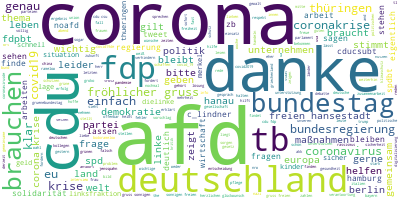

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(sample_df['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#fig, axs = plt.subplots(1,2)

#df['korisnika'].plot(ax=axs[0])
#df['osiguranika'].plot(ax=axs[1])

### Wordcloud Gegenüberstellung

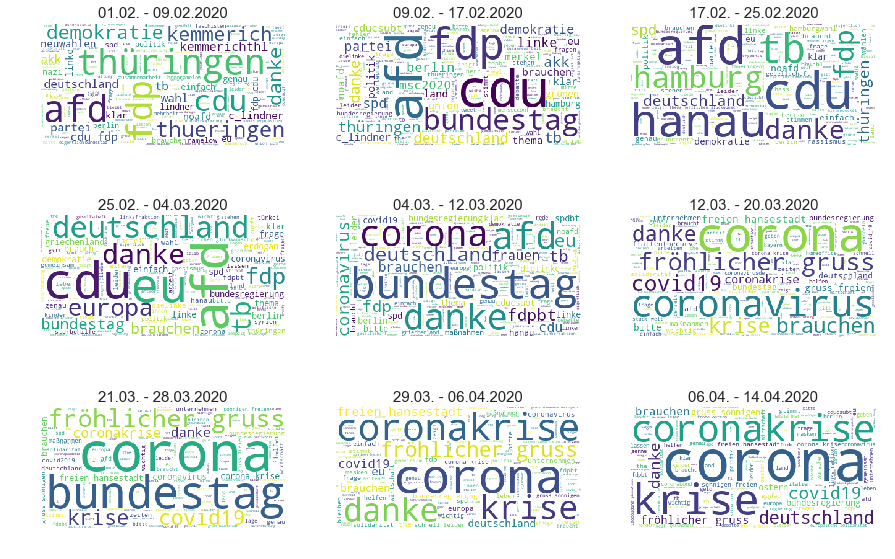

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud


for i in labels:
    weeks['week_'+str(i)] = text_nRT[text_nRT['bins'] == i]  

def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (15, 10))
for i, n in zip(weeks, range(1,10)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    ax = fig.add_subplot(3,3,n, title = title)
    sample_df=weeks[i]
    long_string = ','.join(sample_df['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


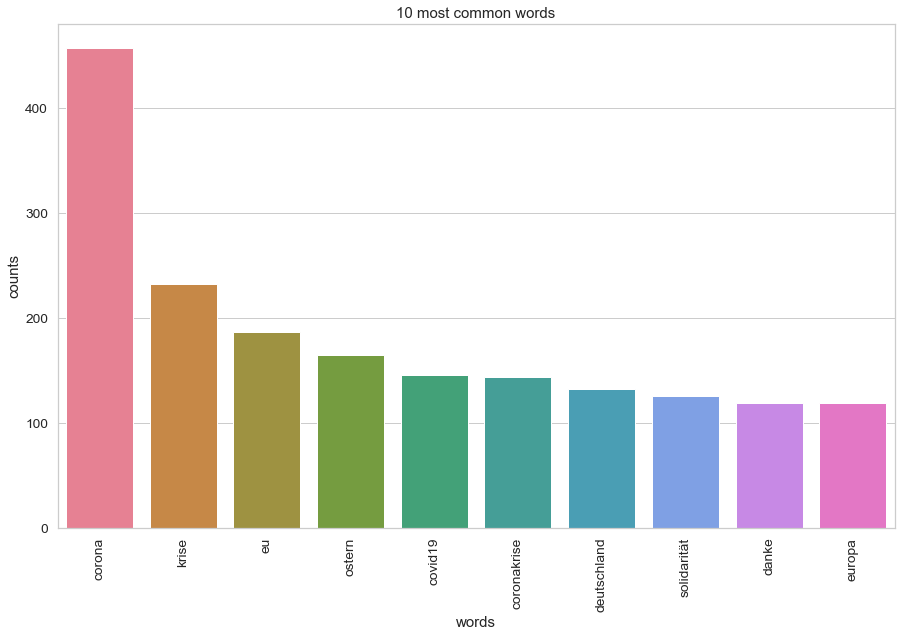

In [49]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the german stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(weeks['week_9']['full_text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


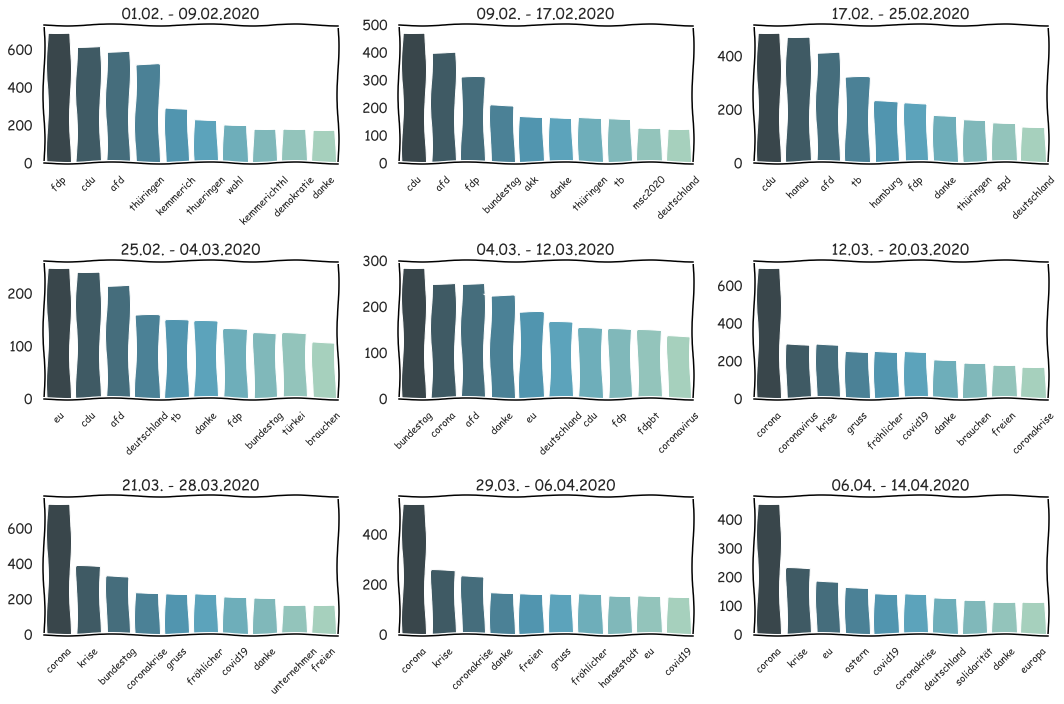

In [116]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0] # total_counts = total_counts + t.toarray
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    with plt.xkcd():
        ax = fig.add_subplot(3,3,n, title =  title)
        fig.tight_layout()
        ax = sns.barplot(x_pos, counts, palette="GnBu_d")
        ax.set_xticklabels(words, rotation = 45, fontsize=10)
        return ax

    
# Initialise the count vectorizer with the german stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)


fig = plt.figure(figsize = (15, 10))
for i, n in zip(weeks, range(1,10)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(weeks[i]['full_text_processed'])
    plot_10_most_common_words(count_data, count_vectorizer, title)
    
plt.show()


In [27]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
fröhlicher gruss freien sonnigen hansestadt corona krise ostern ezb bundesregierung

Topic #1:
corona krise eu ostern wünsche kinder europa deutschland frohe bleiben

Topic #2:
corona stimmt spdde covid19 afd spdbt krise traumschön zeiten einfach

Topic #3:
danke eu solidarität cdu staaten schnell brauchen esm europa eurobonds

Topic #4:
corona krise cducsubt deutschland the coronakrise eu bundesregierung italien fdpbt


In [28]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import os
import pyLDAvis
LDAvis_data_filepath = os.path.join('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+ str(number_topics) +'.html')

CPU times: user 1.73 s, sys: 213 ms, total: 1.94 s
Wall time: 3.53 s


In [29]:
pyLDAvis.display(LDAvis_prepared)

In [48]:
import nltk
#nltk.download('punkt')
from nltk import word_tokenize 
from nltk.util import ngrams

bigram=[]

for tweet in sample_df['full_text_processed']:
    word_data = tweet
    tokens = nltk.word_tokenize(word_data) 
    tweets_nsw = [word for word in tokens if not word in stop_words]
    terms_bigram = list(nltk.bigrams(tweets_nsw))
    bigram.append(terms_bigram)


In [50]:
import itertools
import collections
terms_bigram = bigram

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(fröhlicher, gruss)",105
1,"(gruss, sonnigen)",98
2,"(freien, hansestadt)",97
3,"(sonnigen, freien)",93
4,"(europäische, solidarität)",43
5,"(frohe, ostern)",42
6,"(gelingen, verliebt)",35
7,"(eu, verträgen)",34
8,"(wg, eu)",34
9,"(eurobonds, schnell)",34


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


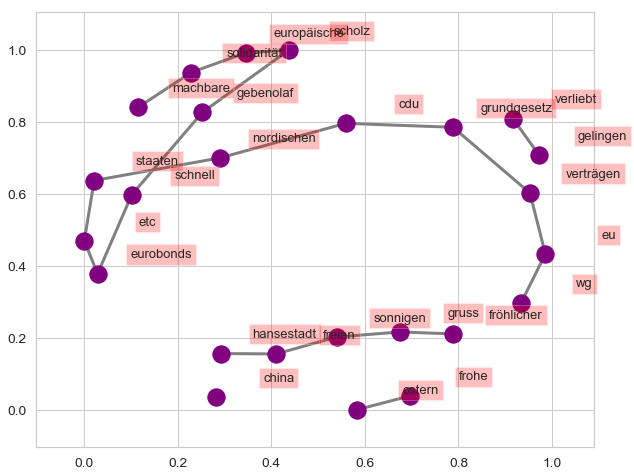

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [16]:
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df['full_text_processed'][8]) 

print(blob.sentences)

print(blob.tokens)

print(blob.tags)

print(blob.noun_phrases)

print(blob.sentiment)

[Sentence("faznet fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt")]
['faznet', 'fordern', 'wir', 'schon', 'lange', 'endlich', 'bewegen', 'sich', 'auch', 'die', 'altparteien', 'afdwirkt']
[('faznet', 'NN'), ('fordern', 'VB'), ('wir', 'PRP'), ('schon', 'RB'), ('lange', 'RB'), ('endlich', 'RB'), ('bewegen', 'VB'), ('sich', 'PRP'), ('auch', 'RB'), ('die', 'DT'), ('altparteien', 'NN'), ('afdwirkt', 'NN')]
[]
Sentiment(polarity=0.7, subjectivity=0.0)


In [21]:
sample_df['full_text_processed'][]

'zeitonline_pol fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt '